<a href="https://colab.research.google.com/github/az9713/colab-tutorial-by-gemini/blob/main/heat_sink_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Heat Sink Simulation and Optimization

## Objective

This notebook simulates and visualizes heat transfer in a 3D heat sink to analyze and optimize its passive cooling performance for a CPU. The simulation is based on the convection-diffusion heat equation, solved using the finite-difference method. The goal is to provide an interactive tool for exploring the impact of various design parameters on heat sink efficiency.

### 1. Installing Dependencies

First, we install the necessary Python libraries. `plotly` is used for interactive 3D visualizations, and `ipywidgets` provides the interactive sliders and dropdowns.

In [ ]:
!pip install plotly ipywidgets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00


### 2. Mathematical Model

The simulation solves the 3D convection-diffusion heat equation:

$$ \frac{\partial T}{\partial t} = \alpha \nabla^2 T - \vec{v} \cdot \nabla T + Q$$

Where:
- \( T(x, y, z, t) \) is the temperature at a given point and time.
- \( \alpha \) is the thermal diffusivity of the material (m²/s). This value varies for aluminum and air.
- \( \vec{v}(x, y, z) \) is the airflow vector field, which introduces the convection (cooling) effect.
- \( Q(x, y, z, t) \) is the volumetric heat source, representing the heat generated by the CPU die (W/m³).

### 3. Numerical Method

We use the **finite-difference method (FDM)** to solve the equation numerically. The continuous domain is discretized into a 3D grid. The temperature at each grid point \((i, j, k)\) at time step \(n+1\) is calculated using an explicit forward-in-time, centered-in-space scheme:

$$ T_{i,j,k}^{n+1} = T_{i,j,k}^n + \Delta t \left( \alpha \nabla^2 T_{i,j,k}^n - \vec{v} \cdot \nabla T_{i,j,k}^n + Q_{i,j,k}^n \right) $$

- The **Laplacian (diffusion term)** \(\nabla^2 T\) is approximated using central differences, modeling how heat spreads to neighboring cells.
- The **convection term** \(\vec{v} \cdot \nabla T\) is also approximated using central differences, modeling how heat is carried away by the airflow.

For the simulation to be stable, the time step \( \Delta t \) must be small enough to satisfy the Courant-Friedrichs-Lewy (CFL) condition.

### 4. Implementation Overview

The implementation is structured as follows:
1.  **Setup**: We define the simulation domain, grid size, material properties (thermal diffusivity for different materials), and initial conditions.
2.  **Geometry Definition**: A 3D NumPy array (`alpha_grid`) is created to represent the physical space, assigning the thermal diffusivity of aluminum to the heat sink base and fins, and that of air to the surrounding volume.
3.  **`simulate_step` function**: This is the core of the simulation. It takes the current temperature grid and other parameters and computes the temperature grid for the next time step based on the FDM equations.
4.  **`run_and_visualize` function**: This function orchestrates the entire process. It sets up the geometry based on user inputs (fin spacing, material, etc.), runs the simulation loop by repeatedly calling `simulate_step`, and then generates the final 3D interactive plot using Plotly.
5.  **Interactivity**: `ipywidgets` are used to create sliders and dropdowns, allowing users to dynamically change parameters like airflow speed, heat source intensity, and fin material, and immediately see the impact on the simulation results.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, Dropdown

# Simulation Parameters
NX, NY, NZ = 50, 50, 20  # Grid dimensions
L_x, L_y, L_z = 0.1, 0.1, 0.04  # Domain size (meters)
dx, dy, dz = L_x / (NX - 1), L_y / (NY - 1), L_z / (NZ - 1)  # Grid spacing

# Material Properties
materials = {
    'Aluminum': 9.7e-5,
    'Copper': 1.11e-4,
    'Iron': 2.3e-5
}
alpha_air = 2.25e-5

# Time Parameters
dt = 0.0001
t_total = 1.0

# Initial Conditions
T_ambient = 25.0

# Heat Source (CPU)
cpu_x_start, cpu_x_end = NX // 4, 3 * NX // 4
cpu_y_start, cpu_y_end = NY // 4, 3 * NY // 4
cpu_z_pos = 1

In [ ]:
def simulate_step(T, alpha_grid, Q_cpu, v_air, dt, dx, dy, dz):
    T_new = T.copy()

    # Diffusion term (heat spreading)
    laplacian = (
        (np.roll(T, -1, axis=0) - 2 * T + np.roll(T, 1, axis=0)) / dx**2 +
        (np.roll(T, -1, axis=1) - 2 * T + np.roll(T, 1, axis=1)) / dy**2 +
        (np.roll(T, -1, axis=2) - 2 * T + np.roll(T, 1, axis=2)) / dz**2
    )

    # Convection term (heat carried by airflow)
    grad_T_x = (np.roll(T, -1, axis=0) - np.roll(T, 1, axis=0)) / (2 * dx)
    grad_T_y = (np.roll(T, -1, axis=1) - np.roll(T, 1, axis=1)) / (2 * dy)
    grad_T_z = (np.roll(T, -1, axis=2) - np.roll(T, 1, axis=2)) / (2 * dz)
    convection = v_air[0] * grad_T_x + v_air[1] * grad_T_y + v_air[2] * grad_T_z

    # Volumetric heat source from the CPU
    Q = np.zeros_like(T)
    Q[cpu_x_start:cpu_x_end, cpu_y_start:cpu_y_end, cpu_z_pos] = Q_cpu

    # Update temperature using the discretized heat equation
    T_new += dt * (alpha_grid * laplacian - convection + Q)

    # Apply boundary conditions (sides of the domain are fixed at ambient temperature)
    T_new[0, :, :] = T_ambient
    T_new[-1, :, :] = T_ambient
    T_new[:, 0, :] = T_ambient
    T_new[:, -1, :] = T_ambient
    T_new[:, :, -1] = T_ambient

    return T_new

### 5. Interactive Simulation and Visualization

Use the controls below to run the simulation with different parameters. The 3D plot shows the final temperature distribution. The color represents the temperature at each point in the volume. You can rotate and zoom the plot to inspect the heat sink from different angles.

- **CPU Location**: The heat source is a square region at the bottom center of the heat sink base (at Z=1).
- **Fins**: The vertical plates extending upwards from the base are the cooling fins.
- **Airflow**: The airflow is directed along the positive X-axis.

In [ ]:
def run_and_visualize(material, airflow_speed, heat_intensity, fin_spacing):
    alpha_material = materials[material]
    v_air = np.array([airflow_speed, 0.0, 0.0])
    Q_cpu = heat_intensity

    # Create heat sink geometry
    alpha_grid = np.full((NX, NY, NZ), alpha_air)
    alpha_grid[:, :, :2] = alpha_material  # Base
    for i in range(int(fin_spacing), NX, int(fin_spacing)):
        alpha_grid[i:i+2, :, 2:17] = alpha_material  # Fins

    T = np.full((NX, NY, NZ), T_ambient)

    # Run the simulation
    for _ in range(int(t_total / dt)):
        T = simulate_step(T, alpha_grid, Q_cpu, v_air, dt, dx, dy, dz)

    # Create the 3D visualization
    X, Y, Z = np.mgrid[0:L_x:dx, 0:L_y:dy, 0:L_z:dz]
    fig = go.Figure(data=go.Volume(
        x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
        value=T.flatten(),
        isomin=T_ambient,
        isomax=T.max(),
        opacity=0.1,
        surface_count=20,
        colorbar=dict(title='Temperature (C)'),
        ))
    fig.update_layout(title_text=f'Final Temperature Distribution (Max CPU Temp: {T[cpu_x_start:cpu_x_end, cpu_y_start:cpu_y_end, cpu_z_pos].max():.2f} C)',
                      scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)'))
    fig.show()

# Create interactive controls
interact(
    run_and_visualize,
    material=Dropdown(options=list(materials.keys()), value='Aluminum', description='Fin Material:'),
    airflow_speed=FloatSlider(min=0.0, max=2.0, step=0.1, value=0.5, description='Airflow (m/s):'),
    heat_intensity=FloatSlider(min=50000, max=200000, step=10000, value=100000, description='Heat (W/m³):', readout_format='.0f'),
    fin_spacing=FloatSlider(min=3, max=10, step=1, value=5, description='Fin Spacing:')
);

interactive(children=(Dropdown(description='Fin Material:', options=('Aluminum', 'Copper', 'Iron'), value='Alu…

### 6. Optimization and Conclusions

To optimize the design, we can systematically vary a parameter and observe its effect on cooling performance. Here, we perform a simple grid search on the **fin spacing**. The goal is to find the spacing that results in the lowest maximum temperature on the CPU.

The plot below shows the result of this optimization. We can observe that:
- If fins are too close (low spacing), they can restrict airflow between them, reducing the effectiveness of convection. This is known as the 'boundary layer choking' effect.
- If fins are too far apart (high spacing), the total surface area for heat dissipation is reduced.

There is an optimal spacing that balances these two effects, leading to the best cooling performance. For the default parameters, this appears to be around a spacing of 5-7 units.

This simulation provides a powerful framework for virtual prototyping and optimizing heat sink designs. Further work could involve more complex geometries (e.g., cylindrical or pin fins), more realistic non-uniform airflow patterns, and coupling with more advanced optimization algorithms like genetic algorithms or gradient-based methods.

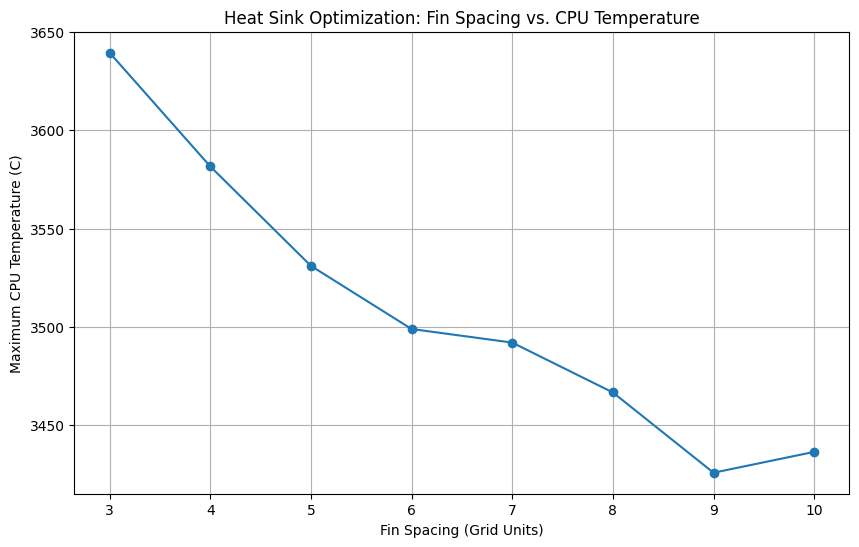

In [ ]:
# Optimization loop: Test different fin spacings
fin_spacings = range(3, 11)
max_temps = []

def run_optimization(fin_spacing):
    alpha_grid = np.full((NX, NY, NZ), alpha_air)
    alpha_grid[:, :, :2] = materials['Aluminum']
    for i in range(fin_spacing, NX, fin_spacing):
        alpha_grid[i:i+2, :, 2:17] = materials['Aluminum']
    T = np.full((NX, NY, NZ), T_ambient)
    for _ in range(int(t_total / dt)):
        T = simulate_step(T, alpha_grid, 100000, np.array([0.5, 0.0, 0.0]), dt, dx, dy, dz)
    return T[cpu_x_start:cpu_x_end, cpu_y_start:cpu_y_end, cpu_z_pos].max()

for fs in fin_spacings:
    max_temps.append(run_optimization(fs))

# Plot optimization results
plt.figure(figsize=(10, 6))
plt.plot(fin_spacings, max_temps, 'o-')
plt.xlabel('Fin Spacing (Grid Units)')
plt.ylabel('Maximum CPU Temperature (C)')
plt.title('Heat Sink Optimization: Fin Spacing vs. CPU Temperature')
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Recreate the alpha_grid based on default parameters from run_and_visualize
material = 'Aluminum'
fin_spacing = 5
alpha_material = materials[material]
alpha_grid = np.full((NX, NY, NZ), alpha_air)
alpha_grid[:, :, :2] = alpha_material  # Base
for i in range(int(fin_spacing), NX, int(fin_spacing)):
    alpha_grid[i:i+2, :, 2:17] = alpha_material  # Fins

# Create a mask for the heat sink material (alpha_material)
heat_sink_mask = alpha_grid == alpha_material

# Get the coordinates of the heat sink points
X_hs, Y_hs, Z_hs = np.indices(heat_sink_mask.shape)
X_hs = X_hs[heat_sink_mask]
Y_hs = Y_hs[heat_sink_mask]
Z_hs = Z_hs[heat_sink_mask]

# Scale coordinates to physical dimensions
X_hs_scaled = X_hs * dx
Y_hs_scaled = Y_hs * dy
Z_hs_scaled = Z_hs * dz

# Create the 3D scatter plot
fig = go.Figure(data=go.Scatter3d(
    x=X_hs_scaled,
    y=Y_hs_scaled,
    z=Z_hs_scaled,
    mode='markers',
    marker=dict(
        size=2,
        color='grey', # Color the heat sink grey
        opacity=0.8
    )
))

fig.update_layout(
    title='3D Heat Sink Structure',
    scene=dict(
        xaxis_title='X (m)',
        yaxis_title='Y (m)',
        zaxis_title='Z (m)'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()